# Gradient example: $\nabla_{M_{vir}^{NFW}}$ (time_integration)

In [ ]:
import os
from functools import partial
# os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt
plt.style.use('default')  # Use default light theme
plt.rcdefaults()



import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})



In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  
# code_units = CodeUnits(code_length, code_mass, G=G)  # default values


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 500, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


In [3]:
#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
# config_com = config._replace(return_snapshots=True,)
# config_com = config._replace(num_snapshots=500, )
params_com = params._replace(t_end=-params.t_end,)



#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

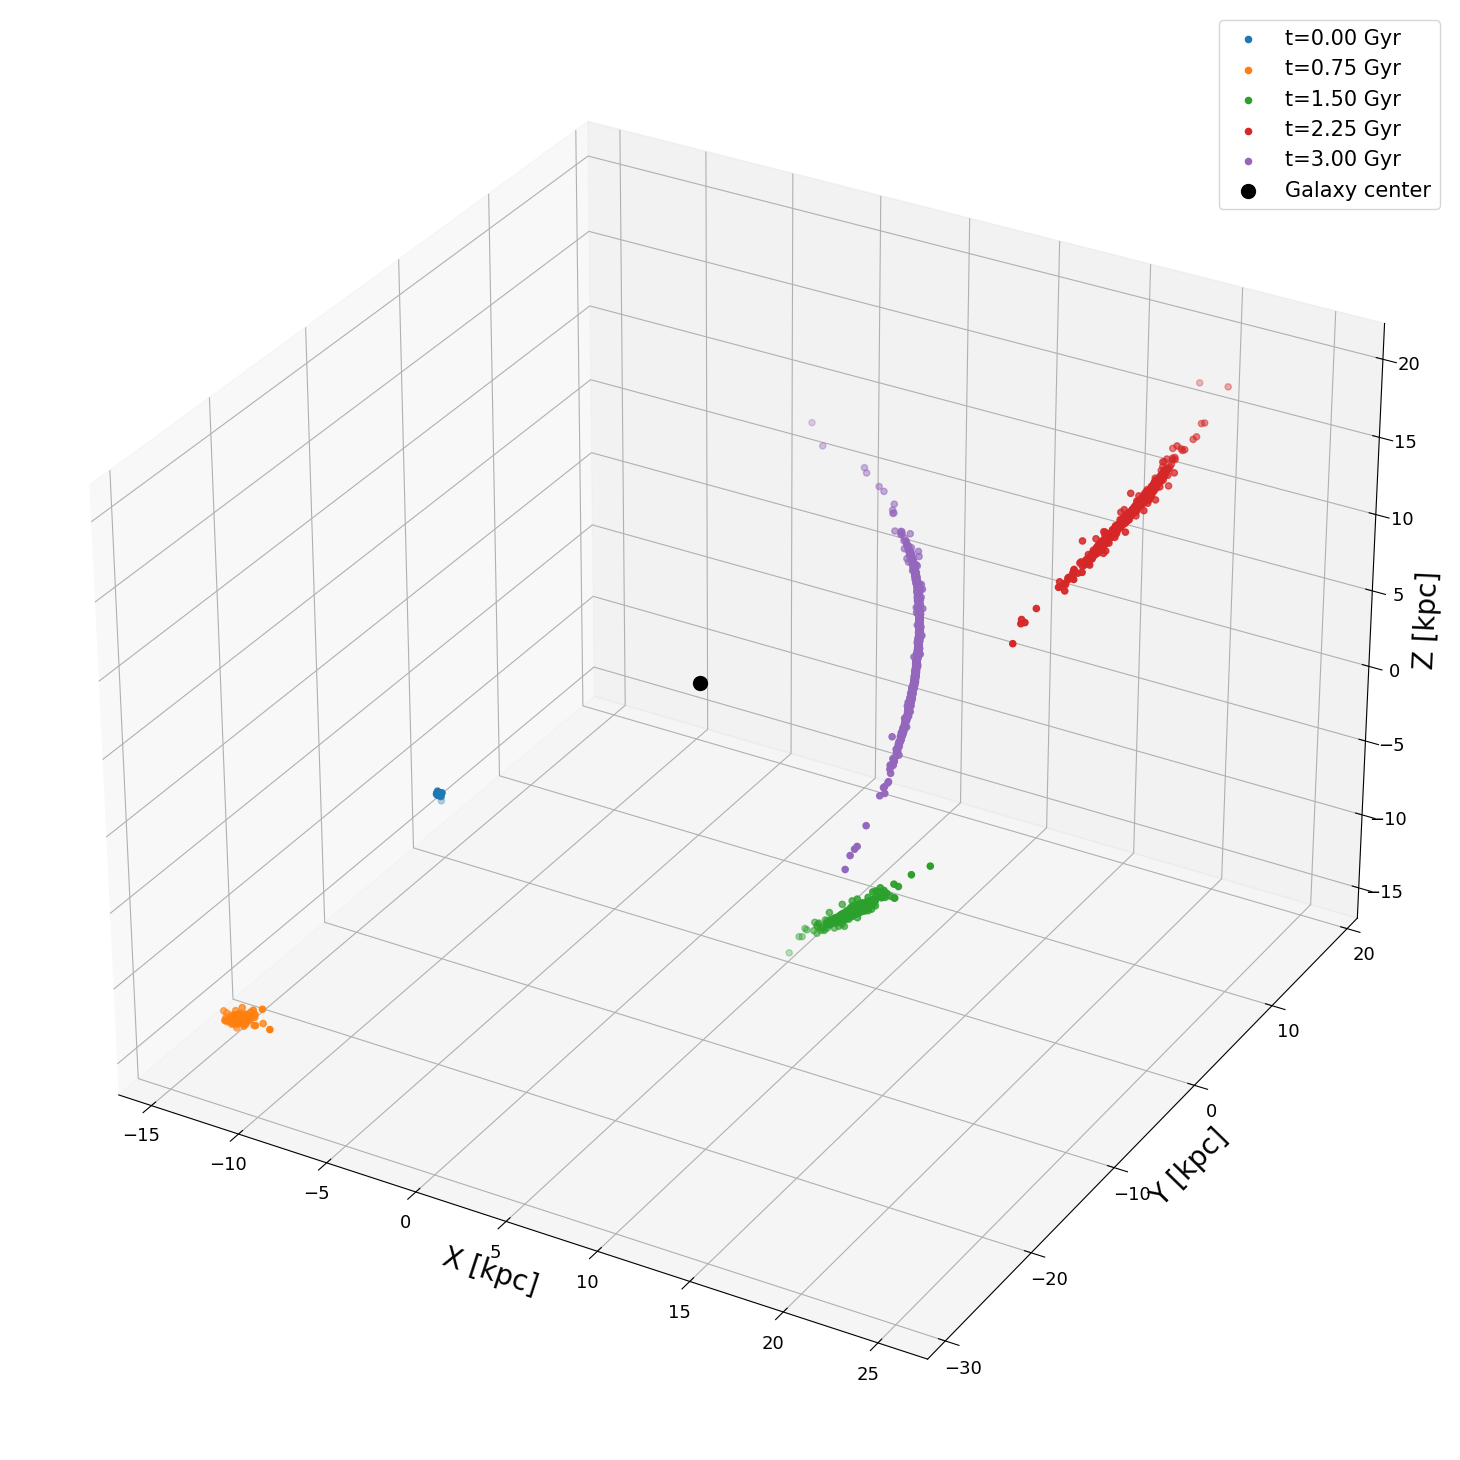

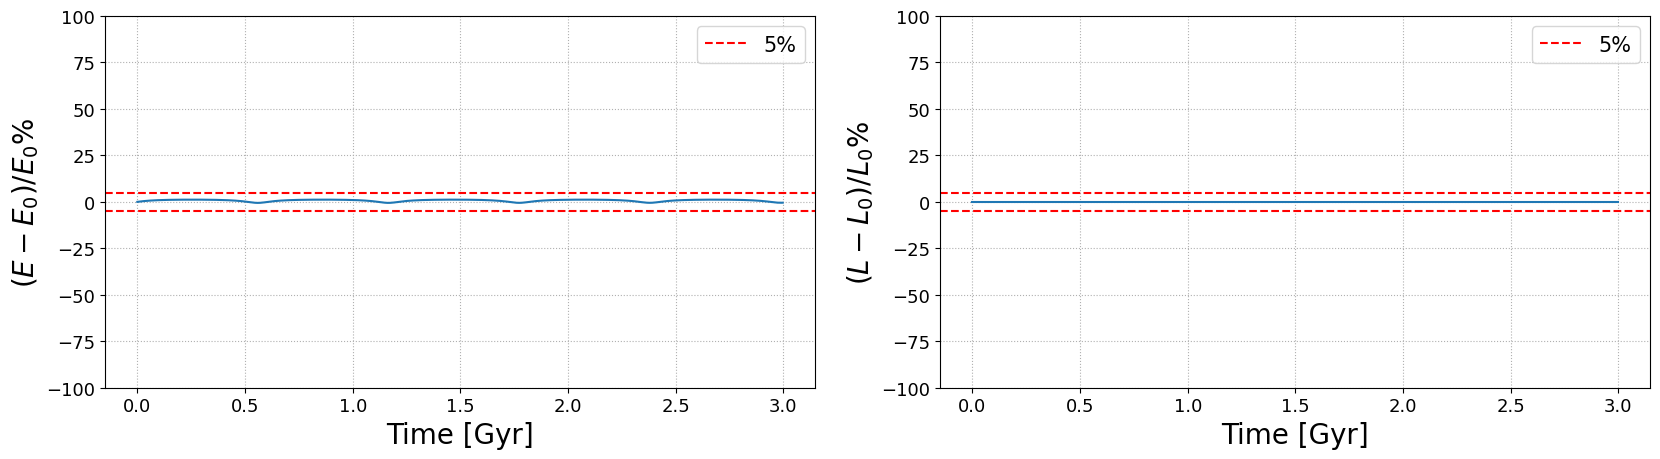

In [ ]:
plt.rcdefaults()
plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

fig = plt.figure(figsize=(15, 15), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, label='Galaxy center')
ax.set_xlabel('X [kpc]')
ax.set_ylabel('Y [kpc]')
ax.set_zlabel('Z [kpc]')
ax.legend()

# fig.savefig('../visualization/image/5_snapshots.png')


energy_angular_momentum_plot(snapshots, code_units,)

In [5]:
final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

final_positions = final_positions * code_units.code_length.to(u.kpc)
final_velocities = final_velocities * code_units.code_velocity.to(u.kpc / u.Myr)

stream_target = projection_on_GD1(final_state, code_units=code_units,)



In [6]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

# @jit
def time_integration_NFW_mass_grad(Mvir, key):

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)


    selected_stream =  stream


    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream

    # loss = -jnp.sum(log_prob)  # We want to minimize the negative log likelihood
    # loss = -jnp.sum(jnp.where(log_prob < 0, log_prob, 0))
    # plt.hist(log_prob, density=False);

    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    sim_norm = normalize_stream(stream)
    target_norm = normalize_stream(stream_target)
    
    @jit 
    def compute_mmd(sim_norm, target_norm, sigmas):
        xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
        yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
        xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
        return xx + yy - 2 * xy

    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    # Adaptive weights based on scale separation
    # scale_weights = jnp.array([0.15, 0.2, 0.3, 0.25, 0.1])
    scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    return mmd_total / len(sigmas)



# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = params.NFW_params.Mvir*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_mass_grad, )(Mvir, key)
# loss = time_integration_NFW_mass_grad(Mvir, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Mvir of NFW:
 -5.7599152e-08
Loss:
 0.0070363344


2025-08-05 09:01:21.810812: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 7.97GiB (8558022527 bytes) by rematerialization; only reduced to 22.67GiB (24341764671 bytes), down from 22.67GiB (24342556891 bytes) originally


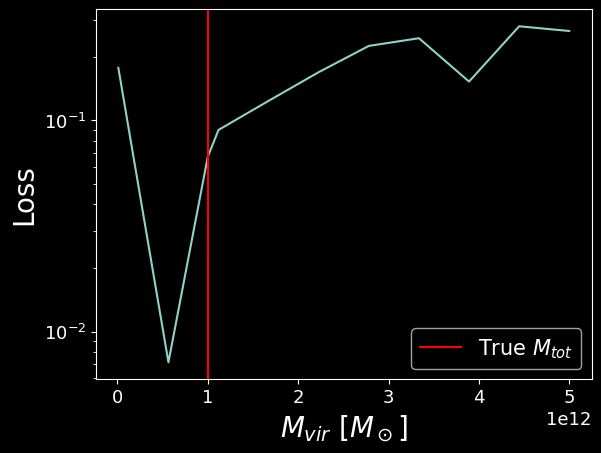

In [7]:
n_sim = 10
keys = jnp.arange(n_sim+1)
Mvir = (np.linspace(0.1*1e11, 5*1e12, n_sim) * u.Msun).to(code_units.code_mass).value
# Correct way to append - assign the result back to Mvir
Mvir = np.concatenate([Mvir, np.array([(1e12 * u.Msun).to(code_units.code_mass).value])]) # Append the true Mvir value
Mvir = jnp.array(np.sort(Mvir))
loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)

plt.figure()
plt.plot((Mvir*code_units.code_mass).to(u.Msun), loss)
plt.axvline((1e12 * u.Msun).value, color='r', label='True $M_{tot}$')
plt.xlabel("$M_{vir}$ [$M_\odot$]")
plt.yscale('log')
# plt.xscale('log')
plt.ylabel('Loss')
plt.legend()


In [15]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit
def time_integration_grad(parameters, key):

    Mvir = parameters[0]
    t_end = parameters[1]
    M_Plummer = parameters[2]
    M_MN = parameters[3]

   #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)
    key_plummer, key_selection, key_background, key_noise = random.split(key, 4)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params = new_params._replace(
                t_end=t_end,
                )
    new_params = new_params._replace(
                Plummer_params=new_params.Plummer_params._replace(
                    Mtot=M_Plummer 
                )
                )
    new_params = new_params._replace(
                MN_params=new_params.MN_params._replace(
                    M=M_MN 
                )
    )
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = new_params_com._replace(
                t_end=-t_end,
                )
    new_params_com = new_params_com._replace(
                Plummer_params=new_params_com.Plummer_params._replace(
                    Mtot=M_Plummer 
                )
                )
    new_params_com = new_params_com._replace(
                MN_params=new_params_com.MN_params._replace(
                    M=M_MN 
                )
    )
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)

    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream

    # loss = -jnp.sum(log_prob)  # We want to minimize the negative log likelihood
    # loss = -jnp.sum(jnp.where(log_prob < 0, log_prob, 0))
    # plt.hist(log_prob, density=False);

    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    def normalize_stream(stream):
        # Normalize each dimension to [0,1]
        return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    # sim_norm = normalize_stream(stream)
    # target_norm = normalize_stream(stream_target)
    sim_norm = stream
    target_norm = stream_target
    
    @jit 
    def compute_mmd(sim_norm, target_norm, sigmas):
        xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
        yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
        xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
        return xx + yy - 2 * xy

    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    # Adaptive weights based on scale separation
    # scale_weights = jnp.array([0.15, 0.2, 0.3, 0.25, 0.1])
    scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    return mmd_total / len(sigmas)



# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = params.NFW_params.Mvir*(3/4) 
t_end = params.t_end * (3/4)
M_Plummer = params.Plummer_params.Mtot * (3/4)
M_MN = params.MN_params.M * (3/4)
parameters = jnp.array([Mvir, t_end, M_Plummer, M_MN])
key = 0
loss, grad = jax.value_and_grad(time_integration_grad, )(parameters, key)
# loss = time_integration_NFW_mass_grad(Mvir, key)
print("Gradient:\n", grad)
print("Loss:\n", loss)  

Gradient:
 [ 6.1641984e-08  9.1263723e-01 -5.4140934e-03  1.3993514e-07]
Loss:
 0.034713216


In [22]:
n_sim = 6
Mvir = jnp.linspace(params.NFW_params.Mvir * 0.5, params.NFW_params.Mvir * 2, n_sim)
t_end = jnp.linspace(params.t_end * 0.5, params.t_end * 2, n_sim)
M_Plummer = jnp.linspace(params.Plummer_params.Mtot * 0.5, params.Plummer_params.Mtot * 2, n_sim)
M_MN = jnp.linspace(params.MN_params.M * 0.5, params.MN_params.M * 2, n_sim)
parameters = jnp.array([Mvir, t_end, M_Plummer, M_MN]).T
key = jnp.arange(n_sim)

loss, grad = jax.vmap(jax.value_and_grad(time_integration_grad, ))(parameters,  key)

In [17]:
grad

Array([[-1.9911397e-09, -4.8049927e-01,  9.1370933e-02, -4.5812669e-09],
       [-5.5422248e-08, -1.3682632e+00, -1.8405212e-02, -1.2658188e-07],
       [ 2.6346152e-08,  4.8556542e-01,  9.6063339e-04,  6.5819982e-08],
       [-1.0135619e-07, -3.3921003e+00, -2.9468507e-04, -2.8801807e-07],
       [ 5.1537132e-08,  2.1584170e+00,  5.2086688e-03,  1.6838470e-07],
       [-1.0080825e-07, -4.3962507e+00,  4.2501944e-03, -3.2695112e-07],
       [-7.3570845e-07, -3.6811115e+01, -7.9653235e-03, -2.7777257e-06],
       [ 4.5167309e-07, -6.2334671e+00,  4.6811424e-02, -6.3137682e-06],
       [-3.1525127e-03, -1.9227053e+05, -9.0761161e-01, -1.7041495e-02],
       [-6.2073288e-03, -5.2436150e+05, -1.7445093e+01, -8.4888399e-02]],      dtype=float32)

In [21]:
parameters[None].shape

(1, 10, 4)